## Food Recommender System

In [1]:
!pwd

/content


In [2]:
import pandas as pd
pd.set_option('display.max_rows',None)

In [3]:
file_path = "/orders_sg25k.txt"
orders = pd.read_csv(file_path)
orders.head()

,Unnamed: 0,customer_id,geohash,order_id,vendor_id,product_id,day_of_week,order_time,order_day
0,0,1ba124d4e5,w21z7,0,212753d2,783e85338f1c,0,12:03:29,85 days
1,1,1ba124d4e5,w21z7,0,212753d2,084ab73246e6,0,12:03:29,85 days
2,2,1ba124d4e5,w21z7,0,212753d2,30eba3cc2676,0,12:03:29,85 days
3,3,1ba124d4e5,w21z7,0,212753d2,3910309eea60,0,12:03:29,85 days
4,4,1ba124d4e5,w21z7,0,212753d2,20049fb602cb,0,12:03:29,85 days


In [4]:
orders.shape

(25000, 9)

## Clean the Data
### Remove Unnecessary Columns

In [5]:
orders.drop(columns=['Unnamed: 0'], inplace=True)

In [6]:
orders.head(3)

,customer_id,geohash,order_id,vendor_id,product_id,day_of_week,order_time,order_day
0,1ba124d4e5,w21z7,0,212753d2,783e85338f1c,0,12:03:29,85 days
1,1ba124d4e5,w21z7,0,212753d2,084ab73246e6,0,12:03:29,85 days
2,1ba124d4e5,w21z7,0,212753d2,30eba3cc2676,0,12:03:29,85 days


In [7]:

file_path2 = "/var/products_sg.txt"
products = pd.read_csv(file_path2)

products.head()

,Unnamed: 0,vendor_id,product_id,name,unit_price
0,0,15bbf316,59099e089514,Meat & Seafood Combo 海鲜套餐,0.0036
1,1,e7b24dc0,52e1017fdbd9,Sausage Egg McMuffin® Meal,0.0024
2,2,e7b24dc0,fcb7110cd932,Scrambled Egg Burger w Chicken Meal,0.0024
3,3,7112a20b,d3e7708c2bc9,Maguro Sushi,0.0012
4,4,6137ef21,bf0d5ac0e03c,Family Meal - Prosp Chic TwLEVMx2 + ChBurgerHM,0.0100


In [8]:
products.drop(columns=['Unnamed: 0'], inplace=True)

In [9]:
products.head(3)

,vendor_id,product_id,name,unit_price
0,15bbf316,59099e089514,Meat & Seafood Combo 海鲜套餐,0.0036
1,e7b24dc0,52e1017fdbd9,Sausage Egg McMuffin® Meal,0.0024
2,e7b24dc0,fcb7110cd932,Scrambled Egg Burger w Chicken Meal,0.0024


In [10]:

file_path3 = "/var/vendors_sg.txt"
vendors = pd.read_csv(file_path3)

vendors.head()

,Unnamed: 0,vendor_id,chain_id,geohash,primary_cuisine
0,0,b160c319,d2786168,w21z6,mexican
1,1,9c8f010e,d2786168,w21ze,mexican
2,4,03eb25e1,5055ab25,w21ze,bak kut teh
3,5,3613129a,8984acb6,w23b1,italian
4,7,0946c9e5,1e3a2913,w21z4,bak kut teh


In [11]:
vendors.drop(columns=['Unnamed: 0'], inplace=True)

In [12]:
vendors.head(3)

,vendor_id,chain_id,geohash,primary_cuisine
0,b160c319,d2786168,w21z6,mexican
1,9c8f010e,d2786168,w21ze,mexican
2,03eb25e1,5055ab25,w21ze,bak kut teh


In [13]:

# Step 1: Merge orders with products on vendor_id and product_id
orders_products = orders.merge(products, on=['vendor_id', 'product_id'], how='left')

# Step 2: Merge the result with vendors on vendor_id
full_data = orders_products.merge(vendors, on='vendor_id', how='left')

# Preview the final merged dataset
full_data.head()

,customer_id,geohash_x,order_id,vendor_id,product_id,day_of_week,order_time,order_day,name,unit_price,chain_id,geohash_y,primary_cuisine
0,1ba124d4e5,w21z7,0,212753d2,783e85338f1c,0,12:03:29,85 days,201. Japanese Garlic Karaage Don,0.0060,66c9978d,w21z7,ramen
1,1ba124d4e5,w21z7,0,212753d2,084ab73246e6,0,12:03:29,85 days,204. Chicken Cutlet Don,0.0068,66c9978d,w21z7,ramen
2,1ba124d4e5,w21z7,0,212753d2,30eba3cc2676,0,12:03:29,85 days,206. Beef Sukiyaki Don,0.0068,66c9978d,w21z7,ramen
3,1ba124d4e5,w21z7,0,212753d2,3910309eea60,0,12:03:29,85 days,209. Japanese Beef Yakiniku Don,0.0068,66c9978d,w21z7,ramen
4,1ba124d4e5,w21z7,0,212753d2,20049fb602cb,0,12:03:29,85 days,210. Teriyaki Salmon Don,0.0080,66c9978d,w21z7,ramen


In [14]:
full_data.describe()

,order_id,day_of_week,unit_price
count,25000.000000,25000.000000,25000.000000
mean,6095.877400,3.240560,0.003454
std,3543.143351,2.002112,0.003289
min,0.000000,0.000000,0.000000
25%,3042.750000,2.000000,0.001600
50%,6047.000000,3.000000,0.002800
75%,9245.000000,5.000000,0.004000
max,12180.000000,6.000000,0.090800


In [15]:
full_data.shape

(25000, 13)

### 👥 Step 2: Analyze Customer Preferences

In [16]:
full_data["primary_cuisine"].nunique()

73

In [17]:
# top 20 most popular cuisines
full_data["primary_cuisine"].value_counts(dropna=False).head(73)

,count
primary_cuisine,
chinese,2682
indian,1529
dessert,1285
noodles,1198
bubble tea,1091
japanese,1065
coffee,1058
mala xiang guo,942
singaporean,853


In [18]:
global_cuisine_category = {
    "japanese": "japanese",
    "ramen": "japanese",
    "sushi": "japanese",

    " korean": " korean",

    "chinese": "chinese",
    "dim sum": "chinese",
    "bak kut teh": "chinese",
    "mala xiang guo": "chinese",
    "mala soups": "chinese",
    "hokkien mee": "chinese",
    "noodles": "chinese",
    "tea": "chinese",

    "indian": "indian",
    "curry": "indian",

    "thai": "thai",

    "vietnamese": "vietnamese",
    "pho": "vietnamese",

    "singaporean": "singaporean",
    "chicken rice": "singaporean",
    "ban mian": "singaporean",
    "yong tau foo": "singaporean",

    "indonesian": "indonesian",
    "ayam penyet": "indonesian",

    "malaysian": "malaysian",
    "nasi lemak": "malaysian",
    "roti prata": "malaysian",

    "american": "american",
    "burgers": "american",
    "fried chicken": "american",
    "chicken": "american",
    "sandwiches": "american",
    "grill": "american",
    "fries": "american",
    "fast food": "american",
    "chicken wings": "american",

    "italian": "italian",
    "pizza": "italian",
    "pasta": "italian",

    "french": "french",
    "german": "german",
    "spanish": "spanish",
    "mexican": "mexican",
    "turkish": "turkish",
    "lebanese": "lebanese",

    # Reassign rice-based dishes
    "rice dishes": "asian",
    "asian": "asian",
    "fried rice": "asian",
    "seafood": "asian",
    "soups": "asian",
    "filipino": "asian",
    "laksa": "asian",
    "porridge": "asian",
    "fish soup": "asian",

    # Everything else defaults to snacks
}


In [19]:
pd.Series(global_cuisine_category.values()).unique()

array(['japanese', ' korean', 'chinese', 'indian', 'thai', 'vietnamese',
       'singaporean', 'indonesian', 'malaysian', 'american', 'italian',
       'french', 'german', 'spanish', 'mexican', 'turkish', 'lebanese',
       'asian'], dtype=object)

In [20]:
pd.Series(global_cuisine_category.values()).nunique()

18

In [21]:
full_data['cuisine_origin'] = full_data['primary_cuisine'].str.strip().map(global_cuisine_category)
full_data['cuisine_origin'].fillna('snacks', inplace=True)


/tmp/ipython-input-2676602241.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_data['cuisine_origin'].fillna('snacks', inplace=True)


In [22]:
print(full_data[['primary_cuisine', 'cuisine_origin']].drop_duplicates().sort_values(by='primary_cuisine'))


            primary_cuisine cuisine_origin
3347              acai bowl         snacks
66                 american       american
51                    asian          asian
170             ayam penyet     indonesian
2915            bak kut teh        chinese
41                   bakery         snacks
2420               ban mian    singaporean
208               beverages         snacks
195              bubble tea         snacks
30                  burgers       american
429                   cakes         snacks
189                 chicken       american
90             chicken rice    singaporean
12491         chicken wings       american
103                 chinese        chinese
57                   coffee         snacks
376                   curry         indian
32                  dessert         snacks
196                dim sum         chinese
889                   donut         snacks
641               fast food       american
12876              filipino          asian
399        

In [23]:
full_data.head()

,customer_id,geohash_x,order_id,vendor_id,product_id,day_of_week,order_time,order_day,name,unit_price,chain_id,geohash_y,primary_cuisine,cuisine_origin
0,1ba124d4e5,w21z7,0,212753d2,783e85338f1c,0,12:03:29,85 days,201. Japanese Garlic Karaage Don,0.0060,66c9978d,w21z7,ramen,japanese
1,1ba124d4e5,w21z7,0,212753d2,084ab73246e6,0,12:03:29,85 days,204. Chicken Cutlet Don,0.0068,66c9978d,w21z7,ramen,japanese
2,1ba124d4e5,w21z7,0,212753d2,30eba3cc2676,0,12:03:29,85 days,206. Beef Sukiyaki Don,0.0068,66c9978d,w21z7,ramen,japanese
3,1ba124d4e5,w21z7,0,212753d2,3910309eea60,0,12:03:29,85 days,209. Japanese Beef Yakiniku Don,0.0068,66c9978d,w21z7,ramen,japanese
4,1ba124d4e5,w21z7,0,212753d2,20049fb602cb,0,12:03:29,85 days,210. Teriyaki Salmon Don,0.0080,66c9978d,w21z7,ramen,japanese


In [24]:
!pwd

/content


In [25]:
full_data[["name"]].to_csv("meals.csv")

In [26]:
df = pd.read_csv('meals.csv')

In [27]:
df.head()

,Unnamed: 0,name
0,0,201. Japanese Garlic Karaage Don
1,1,204. Chicken Cutlet Don
2,2,206. Beef Sukiyaki Don
3,3,209. Japanese Beef Yakiniku Don
4,4,210. Teriyaki Salmon Don


In [28]:
df = df.drop(columns=['Unnamed: 0'], errors='ignore')

### 🟦  Clean the Dish Names

In [29]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\d+\.', '', text)         # Remove leading numbers like "204."
    text = re.sub(r'[^\w\s]', '', text)       # Remove punctuation
    text = re.sub(r'\d+', '', text)           # Remove remaining numbers
    text = text.strip()
    return text

df['name_cleaned'] = df['name'].fillna('').apply(clean_text)


In [30]:
df['name_cleaned'].head()

,name_cleaned
0,japanese garlic karaage don
1,chicken cutlet don
2,beef sukiyaki don
3,japanese beef yakiniku don
4,teriyaki salmon don


### 🟦 Create TF-IDF Matrix

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform
tfidf_matrix = tfidf_vectorizer.fit_transform(df['name_cleaned'])

# Summary
print("✅ TF-IDF matrix created.")
print(f"Matrix shape: {tfidf_matrix.shape}")


✅ TF-IDF matrix created.
Matrix shape: (25000, 6259)


### 🟦 Compute Cosine Similarity

In [32]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute similarity
cosine_sim_matrix = cosine_similarity(tfidf_matrix)

# Preview
#print("✅ Cosine similarity matrix built.")
#print("Top-left 5x5 sample:")
#print(cosine_sim_matrix[:5, :5])


### 🟦  Build Recommender Function

In [33]:
# Create a lookup index using cleaned names, keeping only the first match
indices = df['name_cleaned'].drop_duplicates().reset_index(drop=True)
lookup = pd.Series(indices.index, index=indices.values)


In [34]:
def get_similar_meals(title, cosine_sim=cosine_sim_matrix, lookup=lookup, df=df):
    try:
        title_cleaned = clean_text(title)

        if title_cleaned not in lookup:
            return f"Meal '{title}' not found in the dataset."

        idx = lookup[title_cleaned]

        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = [score for score in sim_scores if score[0] != idx][:10]
        meal_indices = [i[0] for i in sim_scores]

        return df['name_cleaned'].iloc[meal_indices]

    except Exception as e:
        return f"Error: {e}"


### 🟦 Test the Recommender

In [35]:
test_meal = "chicken cutlet don"
similar_meals = get_similar_meals(test_meal)
print(similar_meals)

3242     chicken cutlet don
23020    chicken cutlet don
4546         chicken cutlet
5465       m chicken cutlet
5720         chicken cutlet
9766       a chicken cutlet
9768       a chicken cutlet
15485        chicken cutlet
16851        chicken cutlet
17346        chicken cutlet
Name: name_cleaned, dtype: object


In [36]:
test_meal = "japanese garlic karaage don"
similar_meals = get_similar_meals(test_meal)
print(similar_meals)


3241     japanese garlic karaage don
20413    japanese garlic karaage don
20414    japanese garlic karaage don
10232    japanese karaage curry rice
3         japanese beef yakiniku don
9170      japanese beef yakiniku don
4055                   japanese rice
11416                        karaage
11420                        karaage
16899                        karaage
Name: name_cleaned, dtype: object


In [37]:
test_meal = "sushis"
similar_meals = get_similar_meals(test_meal)
print(similar_meals)

Meal 'sushis' not found in the dataset.


In [38]:
def get_similar_meals_by_keyword(keyword, df=df):
    try:
        keyword_cleaned = clean_text(keyword)

        # Find all meals that contain the keyword
        matches = df[df['name_cleaned'].str.contains(keyword_cleaned, case=False, na=False)]

        if matches.empty:
            return f"No meals found containing '{keyword}'."

        return matches['name_cleaned'].drop_duplicates().reset_index(drop=True)

    except Exception as e:
        return f"Error: {e}"


In [39]:
test_meal = "chicken"
similar_meals = get_similar_meals_by_keyword(test_meal)
similar_meals.head(10)


,name_cleaned
0,chicken cutlet don
1,chicken cutlet with rice
2,chicken chop
3,chicken wings with rice
4,chicken chop with rice
5,butter chicken
6,chicken wing nasi lemak istimewa
7,chicken hor fun 鸡丝河粉
8,chicken piece
9,chicken claw noodle 凤爪面


In [40]:
from sklearn.decomposition import NMF

# --- 3. Define and Fit the NMF Model ---
print(f"--- Fitting NMF model to find topics ---")

# Define the number of "main ideas" you want to find
num_topics = 20

# Initialize NMF
# 'n_components' is the number of topics.
# 'random_state' ensures you get the same results every time you run it.
# 'init='nndsvda'' is a smart initialization method that often leads to better results.
# 'max_iter=500' gives the model more time to converge.
nmf_model = NMF(
    n_components=num_topics,
    random_state=42,
    max_iter=500,
    init='nndsvda'
)

# Fit NMF to our TF-IDF matrix
# This is the main "training" step that discovers the topics.
nmf_model.fit(tfidf_matrix)

print("--- NMF model training complete ---")


# --- 4. Define Function to Display Topics ---

# Get the list of all unique words (the "features") from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

def display_topics(model, feature_names, no_top_words):
    """Prints the top words for each topic found by the model."""
    print("\n--- Discovered Topics (Main Ideas) ---")

    # 'model.components_' is a matrix (topics x words)
    # Each row is a topic, and the values are the "importance" of each word.
    for topic_idx, topic in enumerate(model.components_):

        # Get the index numbers of the top N words for this topic
        top_word_indices = topic.argsort()[:-no_top_words - 1:-1]

        # Get the actual words from their index numbers
        top_words = [feature_names[i] for i in top_word_indices]

        # Print the topic
        print(f"Topic {topic_idx}:")
        print(" ".join(top_words))
        print("-" * 20)

# --- 5. Display the Results ---
# Show the top 8 words for each of our 20 topics.
display_topics(model=nmf_model,
               feature_names=feature_names,
               no_top_words=8)

--- Fitting NMF model to find topics ---
--- NMF model training complete ---

--- Discovered Topics (Main Ideas) ---
Topic 0:
rice 白饭 white steamed roasted plain fragrant glutinous
--------------------
Topic 1:
chicken chop grilled crispy cutlet teriyaki pc wing
--------------------
Topic 2:
tea milk medium green honey caramel thai oolong
--------------------
Topic 3:
set hotplate saba kee sandwich mala create yew
--------------------
Topic 4:
pcs nuggets new separation wings sauce container sushi
--------------------
Topic 5:
egg braised prata salted mayo century sausage 卤蛋
--------------------
Topic 6:
fish sliced porridge 鱼片粥 sweet sour ball chips
--------------------
Topic 7:
large kopi teh iced ovaltine green yakult tea
--------------------
Topic 8:
fried cake prawn carrot thai dumpling seafood prawns
--------------------
Topic 9:
butter toast kaya traditional sugar peanut french naan
--------------------
Topic 10:
noodle meat minced mushroom noodles wanton dry signature
---------

In [41]:
!ls

meals.csv  sample_data


In [42]:
full_data["name"].nunique()

11220

In [43]:
# Example: Filter for Italian cuisine
mexican_orders = full_data[full_data['primary_cuisine'] == 'mexican']


##### 🔸 Most Frequent Customers per Cuisine(mexican cuisine)

In [44]:
top_customers = mexican_orders['customer_id'].value_counts().head(10)
print(top_customers)

customer_id
3307033447    17
a366f0d29a     6
84738d1d40     4
3328cb8066     3
c1cabd59dd     3
30b52b8631     3
53d1c13658     2
7fc1ac1a36     2
1df49d1f92     2
1b0dc4b01c     2
Name: count, dtype: int64


### Most Ordered Products per Cuisine

In [45]:
top_dishes =mexican_orders['name'].value_counts().head(10)
print(top_dishes)


name
Free Heineken 0.0                            9
Honey Tequila Chicken Wings                  4
Spicy Chicken Quesadilla                     4
Roasted Tomato Salsa (Vegan)(Gluten-Free)    3
Rotisserie Chicken                           2
Chico Slaw (VG)                              2
Corn Chips (Vegan)(Gluten-Free)              2
Lamb Tacos (2 Tacos)(Gluten-Free)            2
Roasted Veggies (VG)(GF)                     1
Smoky Chipotle BBQ                           1
Name: count, dtype: int64


### 🔸 Average Spending per Customer

In [46]:
avg_spending = mexican_orders.groupby('customer_id')['unit_price'].mean().sort_values(ascending=False).head(10)
print(avg_spending)


customer_id
6a02b73f91    0.010400
c1cabd59dd    0.007467
3307033447    0.007435
1df49d1f92    0.007200
73a3961ed8    0.005600
f3dbf24141    0.005600
1f1b64c4d2    0.005200
84738d1d40    0.004800
3328cb8066    0.004133
53d1c13658    0.003600
Name: unit_price, dtype: float64


In [47]:
spending_per_customer = mexican_orders.groupby('customer_id')['unit_price'].sum().sort_values(ascending=False).head(10)
print(spending_per_customer)


customer_id
3307033447    0.1264
c1cabd59dd    0.0224
84738d1d40    0.0192
a366f0d29a    0.0168
1df49d1f92    0.0144
3328cb8066    0.0124
6a02b73f91    0.0104
30b52b8631    0.0076
53d1c13658    0.0072
f3dbf24141    0.0056
Name: unit_price, dtype: float64


In [48]:
pip install gensim

### Group Dishes by Order

In [49]:
# Group dish names by order_id
orders2 = full_data.groupby('order_id')['name'].apply(list).tolist()


In [50]:
full_data.head()

,customer_id,geohash_x,order_id,vendor_id,product_id,day_of_week,order_time,order_day,name,unit_price,chain_id,geohash_y,primary_cuisine,cuisine_origin
0,1ba124d4e5,w21z7,0,212753d2,783e85338f1c,0,12:03:29,85 days,201. Japanese Garlic Karaage Don,0.0060,66c9978d,w21z7,ramen,japanese
1,1ba124d4e5,w21z7,0,212753d2,084ab73246e6,0,12:03:29,85 days,204. Chicken Cutlet Don,0.0068,66c9978d,w21z7,ramen,japanese
2,1ba124d4e5,w21z7,0,212753d2,30eba3cc2676,0,12:03:29,85 days,206. Beef Sukiyaki Don,0.0068,66c9978d,w21z7,ramen,japanese
3,1ba124d4e5,w21z7,0,212753d2,3910309eea60,0,12:03:29,85 days,209. Japanese Beef Yakiniku Don,0.0068,66c9978d,w21z7,ramen,japanese
4,1ba124d4e5,w21z7,0,212753d2,20049fb602cb,0,12:03:29,85 days,210. Teriyaki Salmon Don,0.0080,66c9978d,w21z7,ramen,japanese


### Tokenize Dish Names

In [51]:
# Split each dish name into tokens (words)

tokenized_orders = [[dish.lower().split() for dish in order] for order in orders2]

# Flatten inner lists so each order is a list of words
tokenized_orders = [[word for dish in order for word in dish] for order in tokenized_orders]


In [52]:
len(tokenized_orders)

12181

In [53]:
len(tokenized_orders[0])

22

In [54]:
from gensim.models import Word2Vec

# Train the model
model = Word2Vec(sentences=tokenized_orders, vector_size=20, window=5, min_count=2, workers=4, sg=1)


In [55]:
# Find dishes similar to "karaage"
model.wv.most_similar("salmon", topn=5)


[('katsu', 0.9590204358100891),
 ('mentai', 0.9427720308303833),
 ('japanese', 0.9268876910209656),
 ('ebi', 0.926433265209198),
 ('don', 0.9257569313049316)]

In [56]:
# Find dishes similar to "ramen"
model.wv.most_similar("ramen", topn=5)

[('tonkotsu', 0.8800764679908752),
 ('volcano', 0.8445069193840027),
 ('shoyu', 0.8432413935661316),
 ('udon', 0.8295458555221558),
 ('chashu', 0.8278748989105225)]

In [57]:
# Find dishes similar to "pizza"
model.wv.most_similar("pizza", topn=5)

[('single', 0.9292406439781189),
 ('chick', 0.9131549596786499),
 ('feast', 0.8974156975746155),
 ("'n'", 0.8947228789329529),
 ('personal', 0.8946176767349243)]

### 🎨  Word Cloud of Dish Names

In [58]:
pip install wordcloud matplotlib

In [59]:
text = " ".join(full_data['name'].dropna().astype(str).tolist())


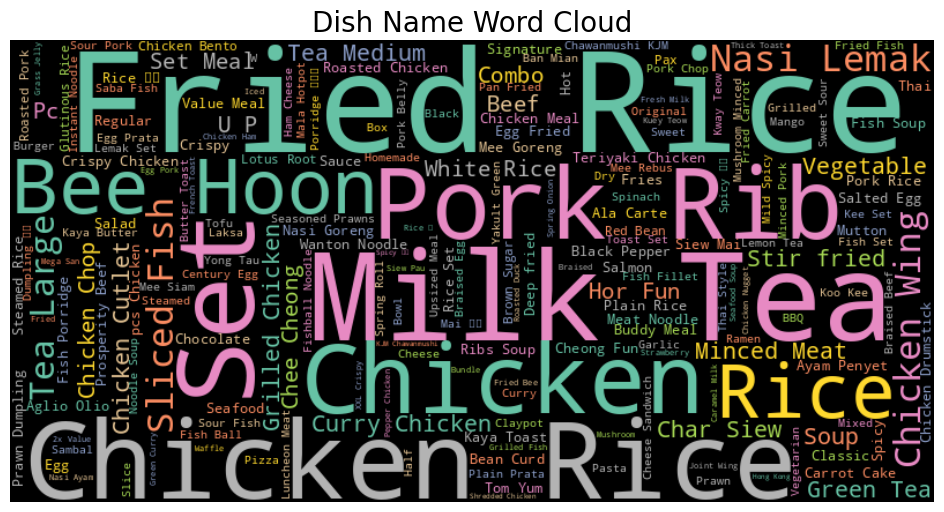

In [60]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Set2').generate(text)

# Display it
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Dish Name Word Cloud", fontsize=20)
plt.show()

### 👥 Top Customers

In [61]:
top_customers = orders['customer_id'].value_counts().head(10)
print(top_customers)


customer_id
50acf8536f    691
857c695baa    182
6a02b73f91    137
e09be49ad4    131
86d7e2a90b    127
b5f64d7c63    119
f43e80b68f    118
35f70335fa    117
4e8b406597    108
ac01e97093    102
Name: count, dtype: int64


### 🗺️ Geohash Distribution

<Axes: title={'center': 'Top Geohash Areas'}, xlabel='geohash'>

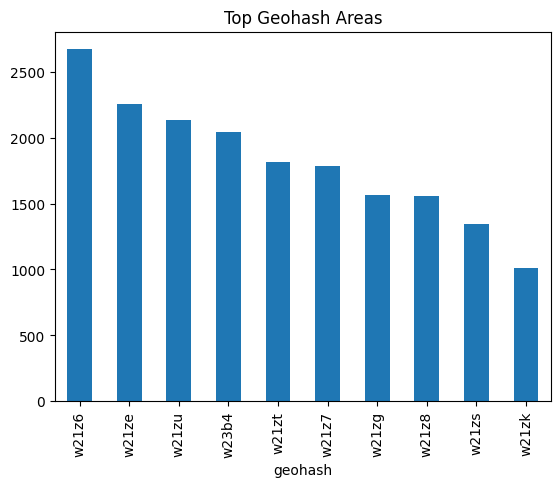

In [62]:
orders['geohash'].value_counts().head(10).plot(kind='bar', title='Top Geohash Areas')

In [63]:
import numpy as np
import pandas as pd

# Set seed for reproducibility (optional)
np.random.seed(42)

# Total number of rows
n_rows =full_data.shape[0]
# Count UNIQUE orders per customer (not rows)
order_counts = full_data.groupby('customer_id')['order_id'].nunique()

# Map order counts back to original dataframe
full_data['order_frequency'] = full_data['customer_id'].map(order_counts)

# Define thresholds based on order frequency quartiles
high_freq_threshold = full_data['order_frequency'].quantile(0.75)
medium_freq_threshold = full_data['order_frequency'].quantile(0.50)


# Initialize rating column
ratings = np.zeros(n_rows)

# Assign ratings based on order frequency
for idx in range(n_rows):
    order_freq = full_data.iloc[idx, full_data.columns.get_loc('order_frequency')]

    if order_freq >= high_freq_threshold:
        # Most frequent orders: mostly 5 stars
        ratings[idx] = np.random.choice([5, 4, 3], p=[0.85, 0.10, 0.05])

    elif order_freq >= medium_freq_threshold:
        # Medium frequency: some lower ratings for 1, 2, 3 stars
        ratings[idx] = np.random.choice([5, 4, 3, 2, 1], p=[0.30, 0.25, 0.25, 0.15, 0.05])

    else:
        # Lower frequency: random distribution
        ratings[idx] = np.random.randint(1, 6)

# Add rating column to dataframe
full_data['rating'] = ratings.astype(int)


In [64]:
full_data.head(10)

,customer_id,geohash_x,order_id,vendor_id,product_id,day_of_week,order_time,order_day,name,unit_price,chain_id,geohash_y,primary_cuisine,cuisine_origin,order_frequency,rating
0,1ba124d4e5,w21z7,0,212753d2,783e85338f1c,0,12:03:29,85 days,201. Japanese Garlic Karaage Don,0.0060,66c9978d,w21z7,ramen,japanese,1,4
1,1ba124d4e5,w21z7,0,212753d2,084ab73246e6,0,12:03:29,85 days,204. Chicken Cutlet Don,0.0068,66c9978d,w21z7,ramen,japanese,1,5
2,1ba124d4e5,w21z7,0,212753d2,30eba3cc2676,0,12:03:29,85 days,206. Beef Sukiyaki Don,0.0068,66c9978d,w21z7,ramen,japanese,1,3
3,1ba124d4e5,w21z7,0,212753d2,3910309eea60,0,12:03:29,85 days,209. Japanese Beef Yakiniku Don,0.0068,66c9978d,w21z7,ramen,japanese,1,5
4,1ba124d4e5,w21z7,0,212753d2,20049fb602cb,0,12:03:29,85 days,210. Teriyaki Salmon Don,0.0080,66c9978d,w21z7,ramen,japanese,1,5
5,f374c8c54c,w21zt,1,21830106,f245bdf79350,4,19:03:03,61 days,Chicken Cutlet with Rice,0.0020,NaN,w21zt,western,snacks,1,2
6,f374c8c54c,w21zt,1,21830106,146127be77d4,4,19:03:03,61 days,Chicken Chop,0.0028,NaN,w21zt,western,snacks,1,3
7,f374c8c54c,w21zt,1,21830106,6c108c0fb2b9,4,19:03:03,61 days,Chicken Wings with Rice,0.0016,NaN,w21zt,western,snacks,1,3
8,f374c8c54c,w21zt,1,21830106,da422c7836e1,4,19:03:03,61 days,Saba Fish with Rice,0.0024,NaN,w21zt,western,snacks,1,3
9,f374c8c54c,w21zt,1,21830106,01110c80a0fa,4,19:03:03,61 days,Chicken Chop with Rice,0.0020,NaN,w21zt,western,snacks,1,5


**vendors rating generation**


In [65]:
vendors_table=full_data

In [66]:
import numpy as np
import pandas as pd

# Set seed for reproducibility
np.random.seed(42)

# Your cuisine mapping
global_cuisine_category = {
    "japanese": "japanese", "ramen": "japanese", "sushi": "japanese",
    "chinese": "chinese", "dim sum": "chinese", "mala xiang guo": "chinese",
    "mala soups": "chinese", "hokkien mee": "chinese", "noodles": "chinese", "tea": "chinese",
    "indian": "indian", "curry": "indian",
    "thai": "thai",
    "vietnamese": "vietnamese", "pho": "vietnamese",
    "singaporean": "singaporean", "chicken rice": "singaporean",
    "ban mian": "singaporean", "yong tau foo": "singaporean",
    "indonesian": "indonesian", "ayam penyet": "indonesian",
    "malaysian": "malaysian", "nasi lemak": "malaysian", "roti prata": "malaysian",
    "american": "american", "burgers": "american", "sandwiches": "american",
    "grill": "american", "fries": "american", "fast food": "american",
    "italian": "italian", "pizza": "italian", "pasta": "italian",
    "french": "french", "german": "german", "spanish": "spanish",
    "mexican": "mexican", "turkish": "turkish", "lebanese": "lebanese",
    "rice dishes": "asian", "fried rice": "asian", "porridge": "asian",
}

# Map cuisine to cuisine_origin (assuming you have a cuisine column in your data)
# If you already have cuisine_origin in your data, you can skip this step
if 'cuisine_origin' not in vendors_table.columns:
    # Replace 'cuisine_column_name' with whatever column contains the cuisine info
    vendors_table['cuisine_origin'] = vendors_table['primary_cuisine'].str.strip().map(global_cuisine_category)
    vendors_table['cuisine_origin'].fillna('snacks', inplace=True)

# Step 1: Calculate vendor-level statistics
vendor_stats = vendors_table.groupby('vendor_id').agg({
    'order_id': 'nunique',          # number of unique orders
    'customer_id': 'nunique',       # number of unique customers
    'unit_price': 'mean',           # average price
    'cuisine_origin': lambda x: x.mode()[0] if len(x) > 0 else 'other'
}).reset_index()

vendor_stats.columns = ['vendor_id', 'total_orders', 'unique_customers', 'avg_price', 'cuisine_origin']

# Step 2: Assign base rating (3.5 to 4.8) based on popularity
vendor_stats['base_rating'] = 3.5 + (
    0.3 * (vendor_stats['total_orders'] / vendor_stats['total_orders'].max()) +
    0.2 * (vendor_stats['unique_customers'] / vendor_stats['unique_customers'].max()) +
    0.8 * np.random.random(len(vendor_stats))
)

vendor_stats['base_rating'] = vendor_stats['base_rating'].clip(upper=4.8)

# Step 3: Cuisine-based rating adjustments (Asian market context)
cuisine_boost = {
    # Premium Asian cuisines (high expectations)
    'japanese': 0.25,
    'singaporean': 0.20,  # Local favorite
    'vietnamese': 0.15,
    'thai': 0.15,

    # Standard Asian cuisines
    'chinese': 0.10,
    'malaysian': 0.10,
    'indonesian': 0.10,
    'asian': 0.05,

    # Indian (variable quality perception)
    'indian': 0.05,

    # Western cuisines (premium in Asian markets)
    'italian': 0.20,
    'french': 0.25,
    'spanish': 0.15,
    'mexican': 0.10,

    # American (casual dining)
    'american': 0.05,

    # Middle Eastern
    'turkish': 0.10,
    'lebanese': 0.10,

    # European
    'german': 0.10,

    # Default
    'other': 0.0
}

vendor_stats['cuisine_adjustment'] = vendor_stats['cuisine_origin'].map(cuisine_boost).fillna(0)
vendor_stats['base_rating'] = (vendor_stats['base_rating'] + vendor_stats['cuisine_adjustment']).clip(3.0, 5.0)

# Step 4: Assign consistency based on order volume
# High volume vendors = more consistent (less variance in ratings)
vendor_stats['consistency'] = pd.cut(
    vendor_stats['total_orders'],
    bins=[0, 20, 100, np.inf],
    labels=['low', 'medium', 'high']
)

# Step 5: Chain vendors get higher consistency
if 'chain_id' in vendors_table.columns:
    chain_vendors = vendors_table[vendors_table['chain_id'].notna()]['vendor_id'].unique()
    vendor_stats.loc[vendor_stats['vendor_id'].isin(chain_vendors), 'consistency'] = 'high'

# Step 6: Generate rating function
def generate_vendor_rating(base_rating, consistency='medium'):
    """Generate realistic individual rating"""
    consistency_map = {'high': 0.3, 'medium': 0.5, 'low': 0.8}
    std_dev = consistency_map.get(consistency, 0.5)

    # Normal distribution around base rating
    rating = np.random.normal(base_rating, std_dev)

    # Round to nearest 0.5 (half-star system)
    rating = np.round(rating * 2) / 2

    # Clip to valid range
    return np.clip(rating, 1.0, 5.0)

# Step 7: Merge vendor stats back to main dataframe
vendors_table = vendors_table.merge(
    vendor_stats[['vendor_id', 'base_rating', 'consistency']],
    on='vendor_id',
    how='left'
)

# Step 8: Generate individual vendor ratings per row
vendors_table['vendor_rating'] = vendors_table.apply(
    lambda row: generate_vendor_rating(row['base_rating'], row['consistency']),
    axis=1
)

# Step 9: Create final table (removed primary_cuisine)
vendors_table = vendors_table[[
    'customer_id', 'geohash_x', 'order_id', 'vendor_id', 'product_id',
    'day_of_week', 'order_time', 'order_day', 'name', 'unit_price',
    'chain_id', 'geohash_y', 'cuisine_origin', 'vendor_rating'
]].copy()


# Display vendor rating statistics
print("=" * 60)
print("VENDOR RATING STATISTICS BY CUISINE")
print("=" * 60)
print(vendors_table.groupby('cuisine_origin')['vendor_rating'].agg(['mean', 'std', 'count']).round(2))
print("\n")
print("=" * 60)
print("TOP 10 VENDORS BY AVERAGE RATING")
print("=" * 60)
top_vendors = vendors_table.groupby('vendor_id').agg({
    'vendor_rating': 'mean',
    'cuisine_origin': 'first',
    'order_id': 'nunique'
}).sort_values('vendor_rating', ascending=False).head(10)
top_vendors.round(2)

VENDOR RATING STATISTICS BY CUISINE
                mean   std  count
cuisine_origin                   
american        4.06  0.48   2695
asian           4.03  0.50   2515
chinese         4.07  0.48   5834
french          4.25  0.35      2
german          4.00  0.41      4
indian          4.04  0.52   1655
indonesian      4.01  0.54    384
italian         4.20  0.45    761
japanese        4.20  0.42   1725
lebanese        4.00  1.41      2
malaysian       4.10  0.49    863
mexican         3.97  0.53     58
singaporean     4.22  0.50   1706
snacks          3.98  0.44   5911
spanish         3.83  0.29      3
thai            4.11  0.46    739
turkish         4.12  0.57     12
vietnamese      4.27  0.48    131


TOP 10 VENDORS BY AVERAGE RATING


,vendor_rating,cuisine_origin,order_id
vendor_id,,,
04799681,5.0,japanese,1
0311bf94,5.0,snacks,1
c56e9af4,5.0,snacks,1
008dd8fd,5.0,asian,1
2b267f07,5.0,singaporean,1
611c7714,5.0,singaporean,1
21284705,5.0,japanese,1
481a35f5,5.0,japanese,1
c3433cec,5.0,japanese,1


**vendors table with row agregation**


In [68]:
# Aggregate data to order level
vendors_table = vendors_table.groupby(['customer_id', 'geohash_x', 'order_id', 'vendor_id']).agg({
    'day_of_week': 'first',
    'order_time': 'first',
    'order_day': 'first',
    'chain_id': 'first',
    'geohash_y': 'first',
    'cuisine_origin': 'first',
    'vendor_rating': 'mean',  # Average rating across all products in the order
    'product_id': 'count',  # Number of items in order
    'unit_price': 'sum',  # Total order value
    'name': lambda x: ', '.join(x[:3]) + ('...' if len(x) > 3 else '')  # First 3 product names
}).reset_index()

# Rename columns for clarity
vendors_table.rename(columns={
    'product_id': 'num_items',
    'unit_price': 'total_order_value',
    'name': 'items_ordered',
    'vendor_rating': 'avg_vendor_rating'
}, inplace=True)

# Round ratings to 1 decimal
vendors_table['avg_vendor_rating'] = vendors_table['avg_vendor_rating'].round(1)

print(f"Original rows: {len(vendors_table)}")
print(f"Aggregated rows: {len(vendors_table)}")
print("\nSample of aggregated data:")
vendors_table.head()


Original rows: 12181
Aggregated rows: 12181

Sample of aggregated data:


,customer_id,geohash_x,order_id,vendor_id,day_of_week,order_time,order_day,chain_id,geohash_y,cuisine_origin,avg_vendor_rating,num_items,total_order_value,items_ordered
0,008ab40ac0,w21z7,9390,8ace9ccb,2,01:52:03,3 days,aece2f12,w21z7,chinese,4.5,1,0.0004,Spicy中辣
1,008ce71183,w21zb,7057,f0d84faa,5,18:11:48,34 days,fc3b6153,w21zc,chinese,3.8,2,0.0128,"Kway Teow Goreng with Petai & Prawns 虾仁臭豆炒河粉, ..."
2,008ce71183,w21zb,7058,a23e4559,2,19:22:26,31 days,788f82f6,w21zb,american,4.1,4,0.0148,"Tuna D'Licious, Spicy Chicken Pizza Baguette, ..."
3,008ce71183,w21zb,7059,a23e4559,3,18:54:16,18 days,788f82f6,w21zb,american,4.0,4,0.0116,"Tuna D'Licious, Chocolate Eclair, Tuna D'Licio..."
4,008ce71183,w21zb,7060,535e5117,4,18:08:21,54 days,None,w21z8,malaysian,3.7,3,0.0076,"Bee Hoon Goreng, Mutton Chop, Mutton Soup"
